# Experiment: Flashed gratings

### Initialization

#### Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.stats as sts
import pickle as pkl
import ipywidgets as widgets
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from scipy import sparse
from matplotlib import cm

# color maps
cmap_hot = cm.get_cmap('hot')
cmap_viridis = cm.get_cmap('viridis')
cmap_jet = cm.get_cmap('jet')

In [2]:

data_folder = "../data/"
stim_file = "Stiminfo_PVCre_2021_0012_s06_e14.csv"
spike_times_file = "Spiketimes_PVCre_2021_0012_s06_e14.npy"

key_symbol = {'pair':'$(\\theta,\phi)$', 'orientation':'$\\theta$', 'phase':'$\phi$'}

#### Load the stimulus data
**Stimulus data layout:**
```
stim_val = {'pair': [(or1, ph1), (or2, ph2), ...], 'orientation': [...], 'phase': [...]}
stim_id_trial = {'pair': [id1, id2, ...], 'phase': [..], ...}   # corresponding trials
pair_trial_id[orientation_id][phase_id] = [Trial ids]
```

In [3]:
# Stimulus DataFrame
stim = pd.read_csv(data_folder + stim_file)
num_trial = len(stim)
stim_val = {}
trial_stim_id = {}
# 50 trials per orientation-phase pair
stim_val['pair'], trial_stim_id['pair'] = np.unique(stim[['grat_orientation', 'grat_phase']], return_inverse=True, axis=0) 
# 1000 trials per orientation
stim_val['orientation'], trial_stim_id['orientation'] = np.unique(stim['grat_orientation'], return_inverse=True) 
# 1000 trials per phase
stim_val['phase'], trial_stim_id['phase'] = np.unique(stim['grat_phase'], return_inverse=True) 
key_list = ['pair', 'orientation', 'phase']
stim_id_trial = {}
num_stim = {}
for key in key_list:
    stim_id_trial[key] = [np.where(trial_stim_id[key] == i)[0] for i in range(len(stim_val[key]))]
    num_stim[key] = len(stim_val[key])

def pair_id(i):
    return (int(i//num_stim['orientation']), i%num_stim['orientation'])

trial_pair_id = np.array([pair_id(i) for i in trial_stim_id['pair']], dtype=object)
pair_val = stim_val['pair'].reshape(num_stim['orientation'], num_stim['phase'],2)

# for each (orientation_id = i, phase_id = j) find the trial indices
pair_trial_id = np.ndarray((num_stim['orientation'], num_stim['phase']), dtype=object)
for i in range(num_stim['pair']):
    pair_trial_id[pair_id(i)] = stim_id_trial['pair'][i]

In [4]:
stim.head()

Unnamed: 0  grat_orientation  grat_phase  stimvals  stim_ontime  \
0           0              45.0        36.0       102       2.5005   
1           1               0.0        18.0         1       2.6195   
2           2             162.0       288.0       376       2.7030   
3           3               0.0        54.0         3       2.7865   
4           4             108.0        36.0       242       2.8700   

   stim_offtime  
0        2.5839  
1        2.7028  
2        2.7863  
3        2.8699  
4        2.9534

In [5]:
print(', '.join(stim_val.keys()))
print(stim_val['pair'].shape)
print(stim_val['orientation'].shape, stim_val['phase'].shape)

pair, orientation, phase
(400, 2)
(20,) (20,)


In [6]:
print(stim_id_trial['pair'][0])

[   82   482  1021  1421  1821  2183  2645  3045  3445  3643  4357  4757
  5014  5493  5893  6293  6693  6965  7365  7652  8052  8513  9116  9203
  9603 10003 10628 10849 11512 11912 12312 12535 12947 13347 13666 14248
 14682 14857 15257 15657 16393 16793 17193 17262 17906 18146 18546 19050
 19450 19904]


In [7]:
pair_trial_id[0][0]

array([   82,   482,  1021,  1421,  1821,  2183,  2645,  3045,  3445,
        3643,  4357,  4757,  5014,  5493,  5893,  6293,  6693,  6965,
        7365,  7652,  8052,  8513,  9116,  9203,  9603, 10003, 10628,
       10849, 11512, 11912, 12312, 12535, 12947, 13347, 13666, 14248,
       14682, 14857, 15257, 15657, 16393, 16793, 17193, 17262, 17906,
       18146, 18546, 19050, 19450, 19904])

**Stimulus data layout:**
```
stim_val = {'pair': [(or1, ph1), (or2, ph2), ...], 'orientation': [...], 'phase': [...]}
stim_id_trial = {'pair': [id1, id2, ...], 'phase': [..], ...}   # corresponding trials
pair_trial_id[orientation_id][phase_id] = [Trial ids]
```

#### Load the spike data and correlations
```
Loaded: spike_count_rate, avg_firing_rate, sem_firing_rate, firing_rate, stim_num_trial, C_r_fphi_theta, theta_hist, phase_hist, pair_hist
Loaded: corr_stim_unit, optimal_avg_firing_rate, stim_hist, stim_hist_caution
```

In [8]:
spike_times_file = "Spiketimes_PVCre_2021_0012_s06_e14.npy"
spike_times = np.load(data_folder+spike_times_file, allow_pickle=True)
active = [len(spike_times[i]) > 0 for i in range(len(spike_times))]
spike_times = spike_times[np.where(active)]
num_unit = len(spike_times)
spike_times.shape

(40,)

**Sort spikes by firing rate**

In [9]:

num_spike = list(map(len, spike_times))
spike_times = spike_times[np.argsort(num_spike)[::-1]]

**Load a lot of variables out of a `.pkl` file**

In [10]:
# yeah...
files = ['spike_data.pkl', 'corr_data.pkl']
for file_name in files:
    file = open(file_name, 'rb')
    data = pkl.load(file)
    print('Loaded:', ', '.join(data.keys()))
    for key, value in data.items():
        globals()[key] = value

    file.close()

Loaded: spike_count_rate, avg_firing_rate, sem_firing_rate, firing_rate, stim_num_trial, C_r_fphi_theta, theta_hist, phase_hist, pair_hist
Loaded: corr_stim_unit, optimal_avg_firing_rate, stim_hist, stim_hist_caution


#### Spike and stimulus preprocessing

```
B_stim = {'pair': [mat_stim_1, mat_stim_2, ..], 'orientation': .., ...}
```

`mat_stim_i` is a matrix of shape `(1, M)` such that `mat[0][t] = 1` if there was stimuli at time $t$ and $0$ if not

```
B_spike = [unit_1_spikes, unit_2_spikes, ..]
unit_1_spikes[t] = 1 if there was a spike, 0 if not
```

##### Read the data

In [11]:
# reverse correlation time offset range 
max_delay = 300 # dt
tau_id_range = np.arange(max_delay)

# experiment duration
latest_spike_time = max([np.max(s) for s in spike_times if len(s)])
latest_stim_offtime = list(stim['stim_offtime'])[-1]
experiment_dur = max([latest_spike_time, latest_stim_offtime])

dt = 0.001 # 1 ms
exp_time = np.arange(0, experiment_dur, dt)
M = len(exp_time)

In [12]:
B_stim = {}
for key in key_list:
    B_stim[key] = []
    for stim_id, trials in enumerate(stim_id_trial[key]):
        B_stim[key].append([])
        s = []
        for trial_id in trials:
            t_on, t_off = stim['stim_ontime'][trial_id], stim['stim_offtime'][trial_id]
            s += list(np.arange(int(t_on//dt), int(t_off//dt)))

        B_stim[key][stim_id] = sparse.coo_matrix((np.ones(len(s)), (np.zeros(len(s), dtype=int), s)), shape=(1, M))
s = spike_times//dt
B_spike = []
for unit_id in range(num_unit):
    B_spike.append(sparse.coo_matrix((np.ones(len(s[unit_id])), (np.zeros(len(s[unit_id]), dtype=int), np.int0(s[unit_id]))), shape=(1, M)))

In [13]:
sorted_spike_num = np.sort(num_spike)[::-1]
cutoff_num_spike = 1000
num_unit = np.sum(sorted_spike_num > cutoff_num_spike)
for key in key_list:
    stim_hist[key] = stim_hist[key][:num_unit]

##### Some plots

This graph shows for unit 0 at a particular moment:
- One stimulus duration (blue)
- The second stimulus (red)

And spike events

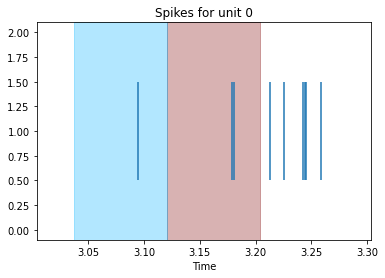

In [14]:
stim_id = 10
trial_id = stim_id_trial['phase'][stim_id][0]
unit_id = 0
t_on, t_off = stim['stim_ontime'][trial_id], stim['stim_offtime'][trial_id]
t0, t1 = t_off-0.2, t_off+0.1
stim_prev_id = trial_stim_id['phase'][trial_id-1]
t_prev_on, t_prev_off = stim['stim_ontime'][trial_id-1], stim['stim_offtime'][trial_id-1]
spikes = spike_times[unit_id][np.where((t0 < spike_times[unit_id]) & (spike_times[unit_id] < t1))]
plt.axvspan(t_on, t_off, color=cmap_jet(1-np.abs(stim_id-10)/10), alpha=0.3)
plt.axvspan(t_prev_on, t_prev_off, color=cmap_jet(1-np.abs(stim_prev_id-10)/10), alpha=0.3)
plt.eventplot(spikes)
plt.xlim([t0, t1])
plt.title('Spikes for unit 0')
plt.xlabel('Time')
plt.show()

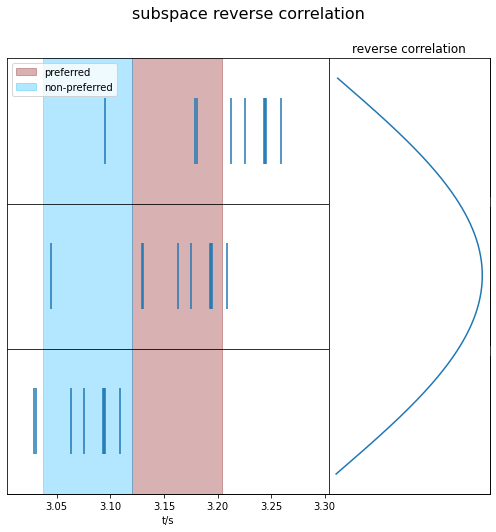

In [15]:
from matplotlib import gridspec

fig, ax = plt.subplots(3,1,figsize=(7,7))
gs0 = gridspec.GridSpec(3, 3, figure=fig, hspace=0, wspace=0)

stim_id = 10
trial_id = stim_id_trial['phase'][stim_id][0]
unit_id = 0
t_on, t_off = stim['stim_ontime'][trial_id], stim['stim_offtime'][trial_id]
t0, t1 = t_off-0.2, t_off+0.1
stim_prev_id = trial_stim_id['phase'][trial_id-1]
t_prev_on, t_prev_off = stim['stim_ontime'][trial_id-1], stim['stim_offtime'][trial_id-1]
spikes = spike_times[unit_id][np.where((t0 < spike_times[unit_id]) & (spike_times[unit_id] < t1))]

ax0 = fig.add_subplot(gs0[0, :-1])
ax1 = fig.add_subplot(gs0[1, :-1])
ax2 = fig.add_subplot(gs0[2, :-1])
ax3 = fig.add_subplot(gs0[:, -1])

ax0.axvspan(t_on, t_off, color=cmap_jet(1-np.abs(stim_id-10)/10), alpha=0.3, label='preferred')
ax0.axvspan(t_prev_on, t_prev_off, color=cmap_jet(1-np.abs(stim_prev_id-10)/10), alpha=0.3, label='non-preferred')
ax0.eventplot(spikes)
ax0.set_xlim([t0, t1])
ax0.legend(loc='upper left')

ax1.axvspan(t_on, t_off, color=cmap_jet(1-np.abs(stim_id-10)/10), alpha=0.3)
ax1.axvspan(t_prev_on, t_prev_off, color=cmap_jet(1-np.abs(stim_prev_id-10)/10), alpha=0.3)
ax1.eventplot(spikes-0.05)
ax1.set_xlim([t0, t1])

ax2.axvspan(t_on, t_off, color=cmap_jet(1-np.abs(stim_id-10)/10), alpha=0.3)
ax2.axvspan(t_prev_on, t_prev_off, color=cmap_jet(1-np.abs(stim_prev_id-10)/10), alpha=0.3)
ax2.eventplot(spikes-0.15)
ax2.set_xlim([t0, t1])

ax3.plot(np.sin(np.pi*tau_id_range/300), np.arange(300))
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('reverse correlation')
# ax2.legend()
for ax in fig.get_axes():
    ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

ax2.tick_params(bottom=True, labelbottom=True)
ax2.set_xlabel('t/s')
plt.tight_layout()
fig.suptitle('subspace reverse correlation', size=16, y=1.05)
plt.show()

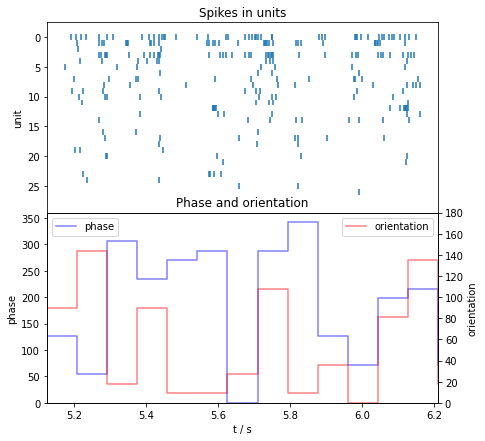

In [16]:
# subspace reverese correlation
stim_id = 13
ref_trial_id = stim_id_trial['phase'][stim_id][0]
stim_prev_id = trial_stim_id['phase'][ref_trial_id-1]
past_trials = 3
future_trials = 10
trial_range = np.arange(-past_trials, future_trials+1) + ref_trial_id

units = np.arange(num_unit)
orientation, phase, t_on = np.array(stim[['grat_orientation', 'grat_phase','stim_ontime']].iloc[trial_range]).T
spikes = [
    spike_times[unit_id][
        # Where the spike occurs during the stimulus period in one of the right trials
        np.where((t_on[0] < spike_times[unit_id]) & (spike_times[unit_id] < t_on[-1]))
        ]
    for unit_id in units]

fig, ax = plt.subplots(2,1,figsize=(7,7))
plt.subplots_adjust(hspace=0)
s = 1
ax[0].eventplot(spikes, linelength=s, lineoffsets=s)

ref_id = list(trial_range).index(ref_trial_id)
# ax[0].axvspan(t_on[ref_id], t_on[ref_id]+0.08, color=cmap_jet(1-np.abs(stim_id-10)/10), alpha=0.3)
# ax[0].axvspan(t_on[ref_id-1], t_on[ref_id-1]+0.08, color=cmap_jet(1-np.abs(stim_prev_id-10)/10), alpha=0.3)
ax[0].set(ylabel='unit')
ax[0].invert_yaxis()
ax[1].step(t_on, phase, 'b', where='post', alpha=0.5, label='phase')
ax[1].set(xlabel='t / s', xlim=[t_on[0], t_on[-1]], ylim=[0, 360], ylabel='phase')
ax[1].legend(loc='upper left')
ax2 = ax[1].twinx()
ax2.step(t_on, orientation, 'r', where='post', alpha=0.5, label='orientation')
ax2.set(ylim=[0, 180], ylabel='orientation')
ax2.legend()
ax[0].set_title('Spikes in units')
ax[1].set_title('Phase and orientation')

plt.show()

In [17]:
@widgets.interact(key=widgets.RadioButtons(options=key_list[1:],
    description='stimulus:',
    disabled=False), tau_id=widgets.IntSlider(0, min=0, max=max_delay-1, description='delay/ms'), unit_id=widgets.IntSlider(0, min=0, max=num_unit-1))

def PSSH(tau_id, unit_id, key):
    fig, ax = plt.subplots(1, 1, figsize=(7,6))
    prob = stim_hist[key][unit_id, tau_id]
    n = sorted_spike_num[unit_id]
    confidence_interval = np.sqrt(prob/n)
    plt.errorbar(stim_val[key], stim_hist[key][unit_id, tau_id], yerr=confidence_interval)
    ymin = np.min(stim_hist[key][unit_id])*0.95
    ymax = np.max(stim_hist[key][unit_id])*1.05
    ax.set_ylabel('$\mathcal{P}($'+key_symbol[key]+'$|\\tau)$')
    ax.set_xlabel(key_symbol[key])
    plt.ylim([ymin, ymax])
    plt.suptitle('Distribution of stimulus at time $\\tau$ before a spike of unit: %d'%unit_id)
    plt.show()

interactive(children=(IntSlider(value=0, description='delay/ms', max=299), IntSlider(value=0, description='uni…

##### Problem with the data

The picture a couple of cells below clearly shows that there is a shift in the stimulus presentation times. Let's fix it!

In [18]:
trial_spike_times = np.ndarray((num_unit, num_trial), dtype=object)
delta_t_on = 0.2 # 200ms
delta_t_off = 0.3
for trial_id in range(num_trial):
    t_on, t_off = stim['stim_ontime'][trial_id]-delta_t_on, stim['stim_offtime'][trial_id]+delta_t_off
    for unit_id in range(num_unit):
        trial_spike_times[unit_id, trial_id] = spike_times[unit_id][np.where((spike_times[unit_id] < t_off) & (spike_times[unit_id] > t_on))]
subseq_trials = 5
subseq_spike_times = np.ndarray(num_unit, dtype=object)
for unit_id in range(num_unit):
    subseq_spike_times[unit_id] = [np.concatenate(trial_spike_times[unit_id][i:i+subseq_trials]) for i in range(num_trial-subseq_trials)]

subseq_spike_times_locked = {}
subseq_spike_times_locked['ontime'] = [subseq_spike_times[unit_id] - stim['stim_ontime'][:-subseq_trials] for unit_id in range(num_unit)]
subseq_spike_times_locked['offtime'] = [subseq_spike_times[unit_id] - stim['stim_offtime'][:-subseq_trials]  for unit_id in range(num_unit)]

/usr/lib/python3.10/site-packages/pandas/core/roperator.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return right - left


In [19]:
time_range = np.arange(0, stim['stim_ontime'].max(), np.array(sorted(np.diff(stim['stim_ontime'], n=1))[10:-10]).mean())

In [20]:
subseq_spike_times_len = len(subseq_spike_times[0])
subseq_spike_times_locked['ontime'] = np.array(subseq_spike_times_locked['ontime'])
subseq_spike_times_locked['offtime'] = np.array(subseq_spike_times_locked['offtime'])
from itertools import chain
subseq_spike_times_locked['ontime'].shape, subseq_spike_times_locked['offtime'].shape, max(chain(*subseq_spike_times_locked['ontime'].flatten()))

((28, 19995), (28, 19995), 0.7671829999999886)

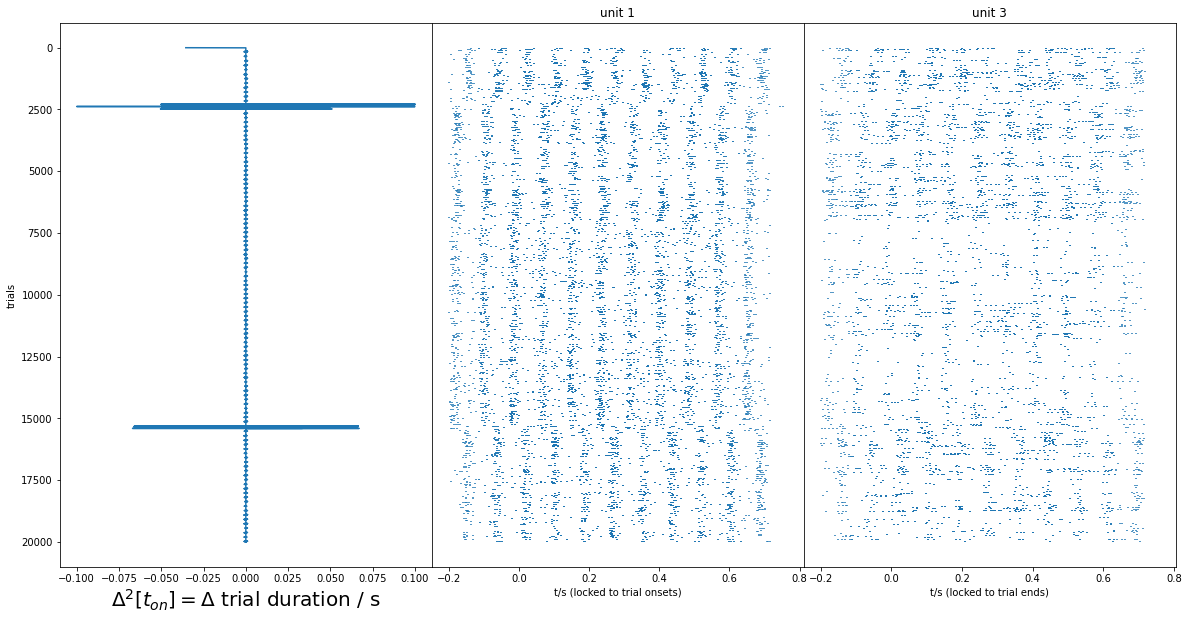

In [21]:
unit_id = 1
unit_id_2 = 3

fig, ax = plt.subplots(1,3, figsize=(20,10))
ax[0].plot(np.diff(stim['stim_ontime'], n=2), np.arange(20000-2))
ax[0].invert_yaxis()
ax[0].set_xlabel('$\Delta^2[t_{on}]=\Delta$ trial duration / s', size=20)
ax[0].set(ylabel='trials')
ax[1].eventplot(subseq_spike_times_locked['ontime'][unit_id], lineoffsets=1, linelengths=0.8)
ax[1].set(title='unit %d'%unit_id, yticks=[], xlabel='t/s (locked to trial onsets)')
ax[1].invert_yaxis()
ax[2].eventplot(subseq_spike_times_locked['ontime'][unit_id_2], lineoffsets=1, linelengths=0.8)
ax[2].set(title='unit %d'%(unit_id_2), yticks=[], xlabel='t/s (locked to trial ends)')
ax[2].invert_yaxis()
plt.subplots_adjust(wspace=0)
plt.show()

_Whaaat?_

Ok, we've gotta fix it.

Let's take the "bad" times, identify the periods we want to calibrate - and align everything

In [22]:
stim_2diffs = np.diff(stim['stim_ontime'], n=2)
print(*[i for i in range(len(stim_2diffs)) if stim_2diffs[i] > 0.01])

2280 2286 2291 2292 2295 2298 2301 2307 2377 2378 2380 2383 2386 2464 2467 2469 2472 2475 2478 15300 15306 15312 15315 15316 15318 15327 15329 15333 15336 15338 15342 15344 15348 15349 15402 15403 15405 15408


Periods:
$[0, 2350)$, $[2350, 15350)$, $[15350, 20000]$

In [23]:
p1, p2 = 2350, 15350
delta_t = 0.002
time_range_smoothing = np.arange(0, 0.8, delta_t)
period_1_dist = np.zeros(len(time_range_smoothing) - 1)
period_2_dist = np.zeros(len(time_range_smoothing) - 1)
period_3_dist = np.zeros(len(time_range_smoothing) - 1)
num_units = subseq_spike_times_locked['ontime'].shape[0]
for i in range(num_units):
    for j, row in enumerate(subseq_spike_times_locked['ontime'][i]):
        hist = np.histogram(row, bins=time_range_smoothing)[0]
        if j < p1:
            period_1_dist += hist
        elif j < p2:
            period_2_dist += hist
        else:
            period_3_dist += hist
period_1_dist /= num_units
period_2_dist /= num_units
period_3_dist /= num_units
period_1_dist = scipy.ndimage.filters.gaussian_filter1d(period_1_dist, sigma=10)
period_2_dist = scipy.ndimage.filters.gaussian_filter1d(period_2_dist, sigma=10)
period_3_dist = scipy.ndimage.filters.gaussian_filter1d(period_3_dist, sigma=10)

/tmp/ipykernel_4135643/175591453.py:20: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  period_1_dist = scipy.ndimage.filters.gaussian_filter1d(period_1_dist, sigma=10)
/tmp/ipykernel_4135643/175591453.py:21: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  period_2_dist = scipy.ndimage.filters.gaussian_filter1d(period_2_dist, sigma=10)
/tmp/ipykernel_4135643/175591453.py:22: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  period_3_dist = scipy.ndimage.filters.gaussian_filter1d(period_3_dist, sigma=10)


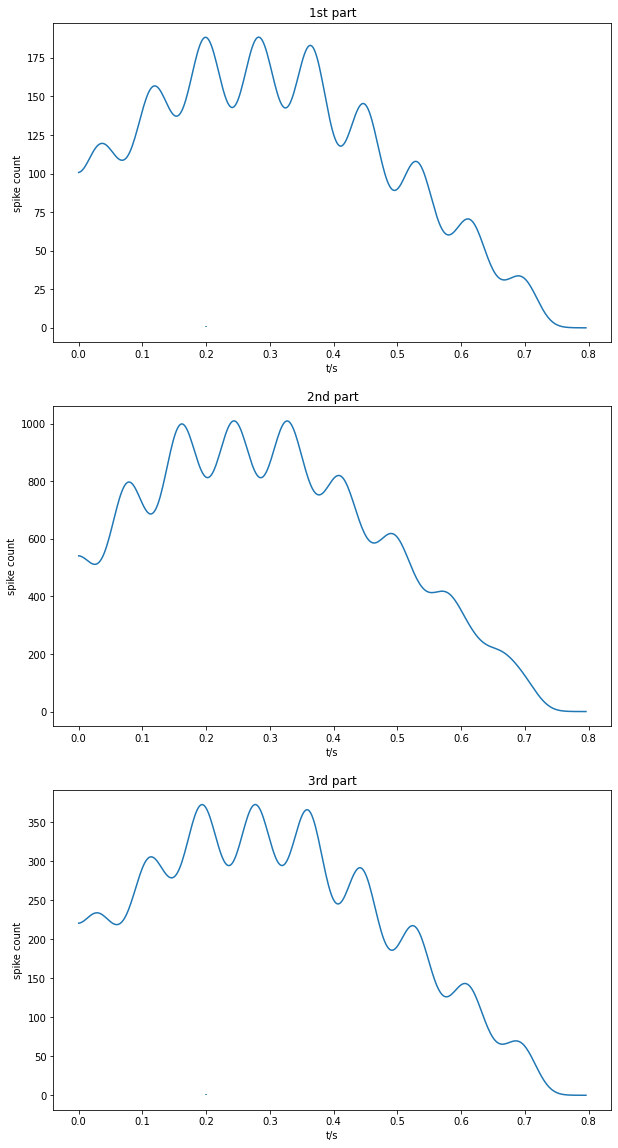

In [24]:
fig, ax = plt.subplots(3, 1, figsize=(10,20))
ax[0].plot(time_range_smoothing[:-1], period_1_dist, label='period 1')
ax[1].plot(time_range_smoothing[:-1], period_2_dist, label='period 2')
ax[2].plot(time_range_smoothing[:-1], period_3_dist, label='period 3')
ax[0].set(xlabel='t/s', ylabel='spike count', title='1st part')
ax[1].set(xlabel='t/s', ylabel='spike count', title='2nd part')
ax[2].set(xlabel='t/s', ylabel='spike count', title='3rd part')
ax[0].eventplot([0.2], linelengths=0.8)
ax[1].eventplot([0.2], linelengths=0.8)
ax[2].eventplot([0.2], linelengths=0.8)

In [25]:
list(time_range_smoothing).index(0.2)

100

In [26]:
max_p_1 = time_range_smoothing[np.argmax(period_1_dist[:120])]
max_p_2 = time_range_smoothing[np.argmax(period_2_dist[:100])]
max_p_3 = time_range_smoothing[np.argmax(period_3_dist[:120])]
delta_2 = max_p_1 - max_p_2
delta_3 = max_p_1 - max_p_3
print(max_p_1, max_p_2, max_p_3)

0.2 0.162 0.194


Now we'll fix the times

In [27]:
t_p1, t_p2 = stim['stim_offtime'][p1], stim['stim_offtime'][p2]
fix_time = lambda t: t - delta_2 * ((t < t_p2) & (t >= t_p1)) - delta_3 * ((t >= t_p2))

In [28]:
fix_time(stim['stim_offtime'][:-subseq_trials])

0           2.5839
1           2.7028
2           2.7863
3           2.8699
4           2.9534
           ...    
19990    1671.6389
19991    1671.7224
19992    1671.8059
19993    1671.8894
19994    1671.9730
Name: stim_offtime, Length: 19995, dtype: float64

In [29]:
subseq_spike_times_locked_2 = {}
subseq_spike_times_locked_2['ontime'] = [subseq_spike_times[unit_id] - fix_time(stim['stim_ontime'][:-subseq_trials]) for unit_id in range(num_unit)]
subseq_spike_times_locked_2['offtime'] = [subseq_spike_times[unit_id] - fix_time(stim['stim_offtime'][:-subseq_trials])  for unit_id in range(num_unit)]

/usr/lib/python3.10/site-packages/pandas/core/roperator.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return right - left


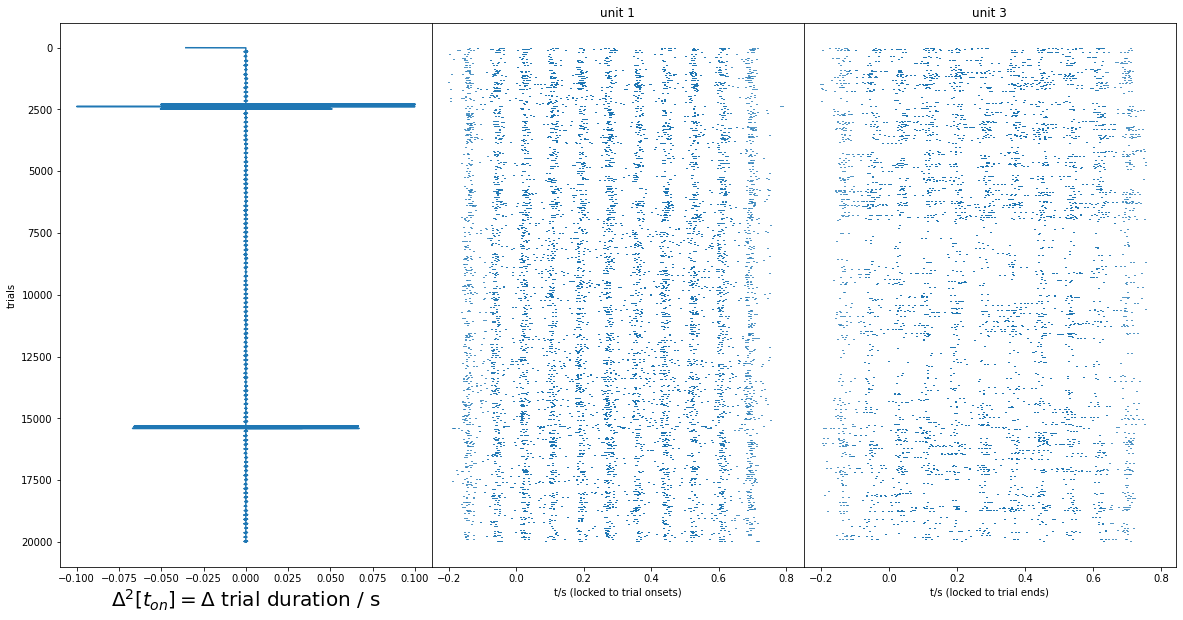

In [30]:
unit_id = 1

fig, ax = plt.subplots(1,3, figsize=(20,10))
ax[0].plot(np.diff(stim['stim_ontime'], n=2), np.arange(20000-2))
ax[0].invert_yaxis()
ax[0].set_xlabel('$\Delta^2[t_{on}]=\Delta$ trial duration / s', size=20)
ax[0].set(ylabel='trials')
ax[1].eventplot(subseq_spike_times_locked_2['ontime'][unit_id], lineoffsets=1, linelengths=0.8)
ax[1].set(title='unit %d'%unit_id, yticks=[], xlabel='t/s (locked to trial onsets)')
ax[1].invert_yaxis()
ax[2].eventplot(subseq_spike_times_locked_2['ontime'][unit_id_2], lineoffsets=1, linelengths=0.8)
ax[2].set(title='unit %d'%(unit_id_2), yticks=[], xlabel='t/s (locked to trial ends)')
ax[2].invert_yaxis()
plt.subplots_adjust(wspace=0)
plt.show()

In [31]:
s = np.array([np.array(list(map(fix_time, spike_times[unit_id]))) for unit_id in range(len(spike_times))], dtype=object)//dt
B_spike_fixed = []
for unit_id in range(num_unit):
    B_spike_fixed.append(sparse.coo_matrix((np.ones(len(s[unit_id])), (np.zeros(len(s[unit_id]), dtype=int), np.int0(s[unit_id]))), shape=(1, M)))

In [32]:
from copy import deepcopy
B_stim_original = deepcopy(B_stim)

In [33]:
B_stim = {}
for key in key_list:
    B_stim[key] = []
    for stim_id, trials in enumerate(stim_id_trial[key]):
        B_stim[key].append([])
        s = []
        for trial_id in trials:
            t_on, t_off = fix_time(stim['stim_ontime'][trial_id]), fix_time(stim['stim_offtime'][trial_id])
            s += list(np.arange(int(t_on//dt), int(t_off//dt)))

        B_stim[key][stim_id] = sparse.coo_matrix((np.ones(len(s)), (np.zeros(len(s), dtype=int), s)), shape=(1, M))

#### Calculate some matrices

In [34]:
get_trial_index = lambda t: fix_time(stim['stim_ontime'][t])//dt

In [35]:
B_spike_smooth = list()
for unit_id in range(num_unit):
    B_spike_smooth.append(scipy.ndimage.gaussian_filter(B_spike[unit_id].toarray()[0], sigma=50))
B_spike_smooth = np.array(B_spike_smooth)

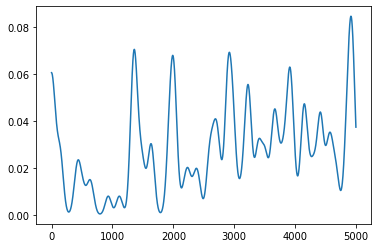

In [36]:
plt.plot(B_spike_smooth[0][:5000])  # ~10 trials